# Multilayer Perceptron

In the previous chapters we showed how you could implement multiclass logistic regression (also called softmax regression) for classifying images of clothing into the 10 possible categories. This is where things start to get fun. We understand how to wrangle data, coerce our outputs into a valid probability distribution (via `softmax`), how to apply an appropriate loss function, and how to optimize over our parameters. Now that we’ve covered these preliminaries, we can extend our toolbox to include deep neural networks.

## Hidden Layers

Recall that before, we mapped our inputs directly onto our outputs through a single linear transformation via

$$
\hat{\mathbf{o}} = \mathrm{softmax}(\mathbf{W} \mathbf{x} + \mathbf{b})
$$

![Single layer perceptron with 5 output units.](../img/singlelayer.svg)

If our labels really were related to our input data by an approximately linear function, then this approach might be adequate. But linearity is a *strong assumption*. Linearity means that given an output of interest, for each input, increasing the value of the input should either drive the value of the output up or drive it down, irrespective of the value of the other inputs.

### From one to many

Imagine the case of classifying cats and dogs based on black and white images. That’s like saying that for each pixel, increasing its value either increases the probability that it depicts a dog or decreases it. That’s not reasonable. After all, the world contains both black dogs and black cats, and both white dogs and white cats.

Teasing out what is depicted in an image generally requires allowing more complex relationships between our inputs and outputs, considering the possibility that our pattern might be characterized by interactions among the many features. In these cases, linear models will have low accuracy. We can model a more general class of functions by incorporating one or more hidden layers. The easiest way to do this is to stack a bunch of layers of neurons on top of each other. Each layer feeds into the layer above it, until we generate an output. This architecture is commonly called a “multilayer perceptron”. With an MLP, we stack a bunch of layers on top of each other. Here's an example:

![Multilayer perceptron with hidden layers. This example contains a hidden layer with 5 hidden units in it. ](../img/mlp.svg)

In the multilayer perceptron above, the number of inputs and outputs is 4 and 3 respectively, and the hidden layer in the middle contains 5 hidden units. Since the input layer does not involve any calculations, there are a total of 2 layers in the multilayer perceptron. The neurons in the hidden layer are fully connected to the inputs within the input layer. The neurons in the output layer and the neurons in the hidden layer are also fully connected. Therefore, both the hidden layer and the output layer in the multilayer perceptron are fully connected layers.

### From linear to nonlinear


Let us write out what is happening mathematically in the picture above, e.g. for multiclass classification.
$$
\begin{aligned}
    \mathbf{h} & = \mathbf{W}_1 \mathbf{x} + \mathbf{b}_1 \\
    \mathbf{o} & = \mathbf{W}_2 \mathbf{h} + \mathbf{b}_2 \\
    \hat{\mathbf{y}} & = \mathrm{softmax}(\mathbf{o})
\end{aligned}
$$

The problem with the approach above is that we have gained nothing over a simple single layer perceptron since we can collapse out the hidden layer by an equivalently parametrized single layer perceptron using $\mathbf{W} = \mathbf{W}_2 \mathbf{W}_1$ and $\mathbf{b} = \mathbf{W}_2 \mathbf{b}_1 + \mathbf{b}_2$.

$$\mathbf{o} = \mathbf{W}_2 \mathbf{h} + \mathbf{b}_2 = \mathbf{W}_2 (\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1) + \mathbf{b}_2 = (\mathbf{W}_2 \mathbf{W}_1) \mathbf{x} + (\mathbf{W}_2 \mathbf{b}_1 + \mathbf{b}_2) = \mathbf{W} \mathbf{x} + \mathbf{b}$$

To fix this we need another key ingredient - a nonlinearity $\sigma$ such as $\mathrm{max}(x,0)$ after each layer. Once we do this, it becomes impossible to merge layers. This yields

$$
\begin{aligned}
    \mathbf{h} & = \sigma(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1) \\
    \mathbf{o} & = \mathbf{W}_2 \mathbf{h} + \mathbf{b}_2 \\
    \hat{\mathbf{y}} & = \mathrm{softmax}(\mathbf{o})
\end{aligned}
$$

Clearly we could continue stacking such hidden layers, e.g. $\mathbf{h}_1 = \sigma(\mathbf{W}_1 \mathbf{x} + \mathbf{b}_1)$ and $\mathbf{h}_2 = \sigma(\mathbf{W}_2 \mathbf{h}_1 + \mathbf{b}_2)$ on top of each other to obtain a true multilayer perceptron.

Multilayer perceptrons can account for complex interactions in the inputs because the hidden neurons depend on the values of each of the inputs. It’s easy to design a hidden node that that does arbitrary computation, such as, for instance, logical operations on its inputs. And it’s even widely known that multilayer perceptrons are universal approximators. That means that even for a single-hidden-layer neural network, with enough nodes, and the right set of weights, it could model any function at all! Actually learning that function is the hard part. And it turns out that we can approximate functions much more compactly if we use deeper (vs wider) neural networks. We’ll get more into the math in a subsequent chapter, but for now let’s actually build an MLP. In this example, we’ll implement a multilayer perceptron with two hidden layers and one output layer.

### Vectorization and mini-batch

When given a mini-batch of samples we can use vectorization to gain better efficiency in implementation. In a nutshell, we replace vectors by matrices. As before, denote by $\mathbf{X}$ the matrix of inputs from a minibatch. Then an MLP with two hidden layers can be expressed as

$$
\begin{aligned}
    \mathbf{H}_1 & = \sigma(\mathbf{W}_1 \mathbf{X} + \mathbf{b}_1) \\
    \mathbf{H}_2 & = \sigma(\mathbf{W}_2 \mathbf{H}_1 + \mathbf{b}_2) \\
    \mathbf{O} & = \mathrm{softmax}(\mathbf{W}_3 \mathbf{H}_2 + \mathbf{b}_3)
\end{aligned}
$$

This is easy to implement and easy to optimize. With some abuse of notation we define the nonlinearity $\sigma$ to apply to its inputs on a row-wise fashion, i.e. one observation at a time, often one coordinate at a time. This is true for most activation functions (the [batch normalization](../chapter_convolutional-neural-networks/batch-norm.md) is a notable exception from that rule).

## Activation Functions

Let us look a bit more at examples of activation functions. After all, it is this alternation between linear and nonlinear terms that makes deep networks work. A rather popular choice, due to its simplicity of implementation and its efficacy is the ReLU function.

### ReLU Function

The ReLU (rectified linear unit) function provides a very simple nonlinear transformation. Given the element $x$, the function is defined as

$$\mathrm{ReLU}(x) = \max(x, 0).$$

It can be understood that the ReLU function retains only positive elements and discards negative elements. To get a better idea of what it looks like it helps to plot it. For convenience we define a plotting function `xyplot` to take care of the gruntwork.

In [1]:
import sys
sys.path.insert(0, '..')

%matplotlib inline
import d2l
from mxnet import autograd, nd

def xyplot(x_vals, y_vals, name):
    d2l.set_figsize(figsize=(5, 2.5))
    d2l.plt.plot(x_vals.asnumpy(), y_vals.asnumpy())
    d2l.plt.xlabel('x')
    d2l.plt.ylabel(name + '(x)')

Then, we can plot the ReLU function using the `relu` function provided by NDArray. As you can see, the activation function is a two-stage linear function.

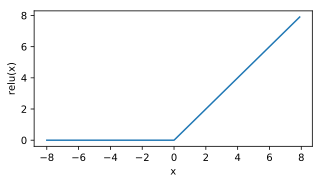

In [2]:
x = nd.arange(-8.0, 8.0, 0.1)
x.attach_grad()
with autograd.record():
    y = x.relu()
xyplot(x, y, 'relu')

Obviously, when the input is negative, the derivative of ReLU function is 0; when the input is positive, the derivative of ReLU function is 1. Note that the ReLU function is not differentiable when the input is 0. Instead, we pick its left-hand-side (LHS) derivative 0 at location 0. The derivative of the ReLU function is plotted below.

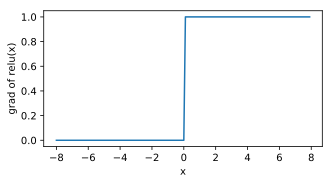

In [3]:
y.backward()
xyplot(x, x.grad, 'grad of relu')

Note that there are many variants to the ReLU function, such as the parameterized ReLU (pReLU) of [He et al., 2015](https://arxiv.org/abs/1502.01852). Effectively it adds a linear term to the ReLU, so some information still gets through, even when the argument is negative.

$$\mathrm{pReLU}(x) = \max(0, x) + \alpha \min(0, x)$$

The reason for using the ReLU is that its derivatives are particularly well behaved - either they vanish or they just let the argument through. This makes optimization better behaved and it reduces the issue of the vanishing gradient problem (more on this later).

### Sigmoid Function

The Sigmoid function can transform the value of an element in $\mathbb{R}$ to the interval $(0,1)$.

$$\mathrm{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.$$

The Sigmoid function was commonly used in early neural networks, but is currently being replaced by the simpler ReLU function. In the "Recurrent Neural Network" chapter, we will describe how to utilize the function’s ability to control the flow of information in a neural network thanks to its capacity to transform the value range between 0 and 1. The derivative of the Sigmoid function is plotted below. When the input is close to 0, the Sigmoid function approaches a linear transformation.

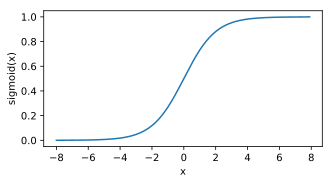

In [4]:
with autograd.record():
    y = x.sigmoid()
xyplot(x, y, 'sigmoid')

The derivative of Sigmoid function is as follows:

$$\frac{d}{dx} \mathrm{sigmoid}(x) = \frac{\exp(-x)}{(1 + \exp(-x))^2} = \mathrm{sigmoid}(x)\left(1-\mathrm{sigmoid}(x)\right).$$


The derivative of Sigmoid function is plotted below. When the input is 0, the derivative of the Sigmoid function reaches a maximum of 0.25; as the input deviates further from 0, the derivative of Sigmoid function approaches 0.

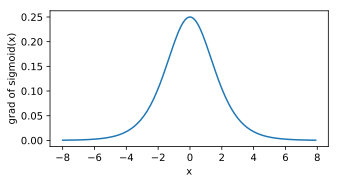

In [5]:
y.backward()
xyplot(x, x.grad, 'grad of sigmoid')

### Tanh Function

The Tanh (Hyperbolic Tangent) function transforms the value of an element to the interval between -1 and 1:

$$\text{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.$$

We can then plot the Tanh function. As the input nears 0, the Tanh function approaches linear transformation. Although the shape of the function is similar to that of the Sigmoid function, the Tanh function is symmetric at the origin of the coordinate system.

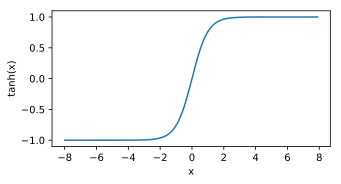

In [6]:
with autograd.record():
    y = x.tanh()
xyplot(x, y, 'tanh')

The derivative of the Tanh function is:

$$\frac{d}{dx} \mathrm{tanh}(x) = 1 - \mathrm{tanh}^2(x).$$

The derivative of Tanh function is plotted below. As the input nears 0, the derivative of the Tanh function approaches a maximum of 1; as the input deviates away from 0, the derivative of the Tanh function approaches 0.

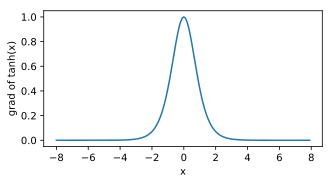

In [7]:
y.backward()
xyplot(x, x.grad, 'grad of tanh')

In summary, we have a range of nonlinearities and now know how to layer them to build quite powerful network architectures. As a side note, we have now pretty much reached the state of the art in deep learning, anno 1990. The main difference is that we have a powerful deep learning framework which lets us build models in a few lines of code where previously thousands of lines of C and Fortran would have been needed.

## Summary

* The multilayer perceptron adds one or multiple fully connected hidden layers between the output and input layers and transforms the output of the hidden layer via an activation function.
* Commonly used activation functions include the ReLU function, the Sigmoid function, and the Tanh function.


## Exercises

1. Compute the derivative of the Tanh and the pReLU activation function.
1. Show that a multilayer perceptron using only ReLU (or pReLU) constructs a continuous piecewise linear function.
1. Show that $\mathrm{tanh}(x) + 1 = 2 \mathrm{sigmoid}(2x)$.
1. Assume we have a multilayer perceptron *without* nonlinearities between the layers. In particular, assume that we have $d$ input dimensions, $d$ output dimensions and that one of the layers had only $d/2$ dimensions. Show that this network is less expressive (powerful) than a single layer perceptron.
1. Assume that we have a nonlinearity that applies to one minibatch at a time. What kinds of problems to you expect this to cause?

## Scan the QR Code to [Discuss](https://discuss.mxnet.io/t/2338)

![](../img/qr_mlp.svg)